# Import data

In [288]:
import os
import pandas as pd
import numpy as np
import scipy as sp

train = pd.read_csv("train.csv")
train_x = train.ix[:,:-1]
train_y = train.ix[:,-1]
test = pd.read_csv("test.csv")

In [2]:
# quick look at data
print train.head(10)
print train.shape

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities    ...     PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN    NaN         NaN       0   
1         Lvl    AllPub

In [3]:
# if test columns == train columns, and they do
test.columns == train.columns[:-1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [4]:
# datatypes
train_x.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

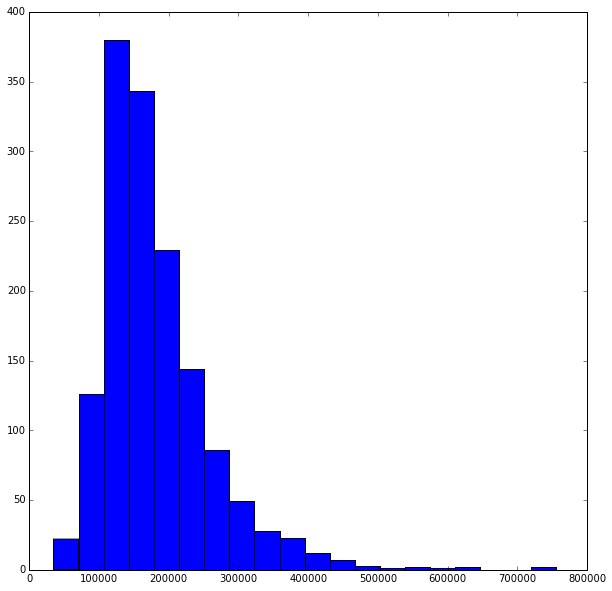

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [5]:
# the distribution of the target (SalePrice)
% matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.hist(train_y, bins = 20)
plt.show()

train_y.describe()

# Linear Regression w/ All Features

In [225]:
def dummy_transform(df):
    # create dummy columns 
    object_columns = df.columns[df.dtypes == 'object']
    #print object_columns.shape
    new_df = df[object_columns].fillna(value = "Nothing1") 
    object_dummies = pd.get_dummies(new_df, drop_first = True)
    #print object_dummies.shape
    
    # new dataframe 
    new_train_x = pd.concat([df, object_dummies], axis=1)
    nonobject_columns = new_train_x.columns[new_train_x.dtypes != "object"]
    #print nonobject_columns.shape
    nonobject_columns = nonobject_columns[1:] # removed id
    new_train_x = new_train_x[nonobject_columns]
    new_train_x.fillna(value = 0, inplace = True) 
    
    return(new_train_x)

In [226]:
# Dummy columns after test transformation, find columns that are the same in both sets
new_test_columns = dummy_transform(test).columns
new_train_columns = dummy_transform(train_x).columns

final_columns=new_test_columns & new_train_columns


In [227]:
# model train
from sklearn.linear_model import LinearRegression

new_train_x = dummy_transform(train_x)[final_columns]
lm = LinearRegression()
lm.fit(new_train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [228]:
# predict 
new_test_x = dummy_transform(test)[final_columns]
pred = lm.predict(new_test_x)
submission = pd.DataFrame({'Id': test.iloc[:,0], 'SalePrice': pred})
submission.loc[submission['SalePrice'] < 0,'SalePrice'] = 0 
submission.to_csv('initial_submission_LM.csv', index = False)

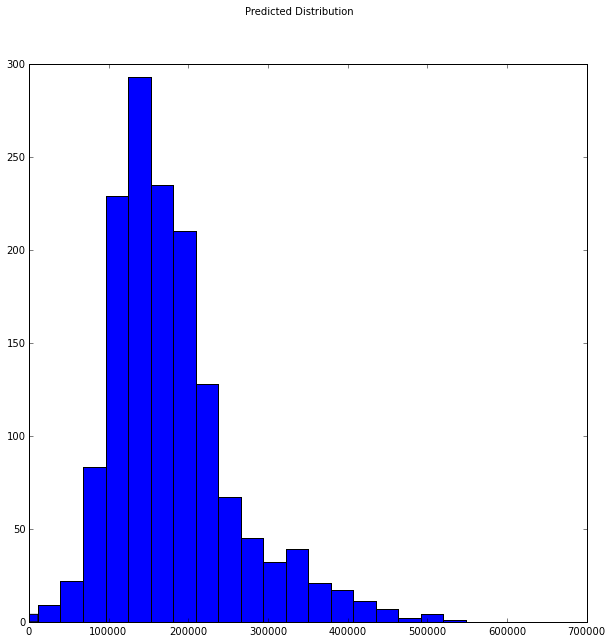

,0
count,1459.000000
mean,178756.230480
std,78359.375247
min,-16816.032945
25%,126321.995737
50%,160405.602586
75%,210829.266621
max,548251.725246


In [223]:
# the distribution of predicted, there are negatives
% matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.hist(pred, bins = 20)
plt.suptitle('Predicted Distribution')
plt.xlim([0,700000])
plt.show()

pd.DataFrame(pred).describe()

# Understanding the Data

Ames is a city located in Iowa in Story County. In 2010 it had a population of 58,965. In 2010, Ames was ranked ninth on CNNMoney.com "Best Places to Live" list.

86% commute by car.
5% commute by public transportation.

Price per Square Ft. ranges from $130 - 140 from Jun 2015 - Jun 2016.

The median household income for the Ames Iowa metro area was $50,811 in 2015

In [233]:
# year range
train['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64


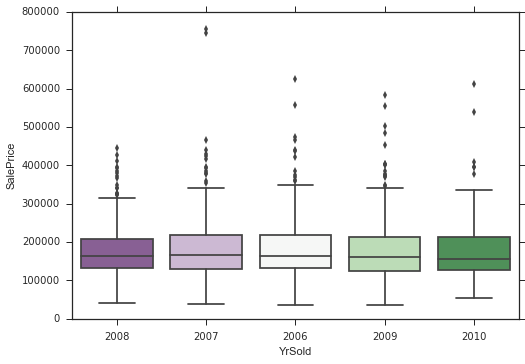

In [318]:
# plot year vs sale price, it looks like all the median sale prices are around the same.
import seaborn as sns
sns.set(style="ticks")
sns.boxplot(x='YrSold', y='SalePrice', data=train, palette="PRGn")

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64
           GrLivArea  SalePrice
GrLivArea   1.000000   0.708624
SalePrice   0.708624   1.000000


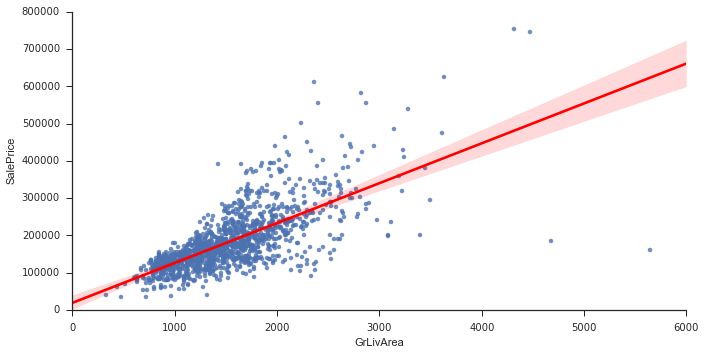

In [373]:
# Lot Area vs Sale Price, based on the scatter plot lot area does not affect the price much. There are a few outliers
# that we should look into compared to the ones in the left cluster.
ax = sns.lmplot(x='GrLivArea',y='SalePrice',
                data=train ,fit_reg=True, 
                aspect = 2, line_kws={'color': 'red'})

ax.axes[0,0].set_ylim(0,800000)

print train['GrLivArea'].describe()

print train[['GrLivArea','SalePrice']].corr()

sns.plt.show()

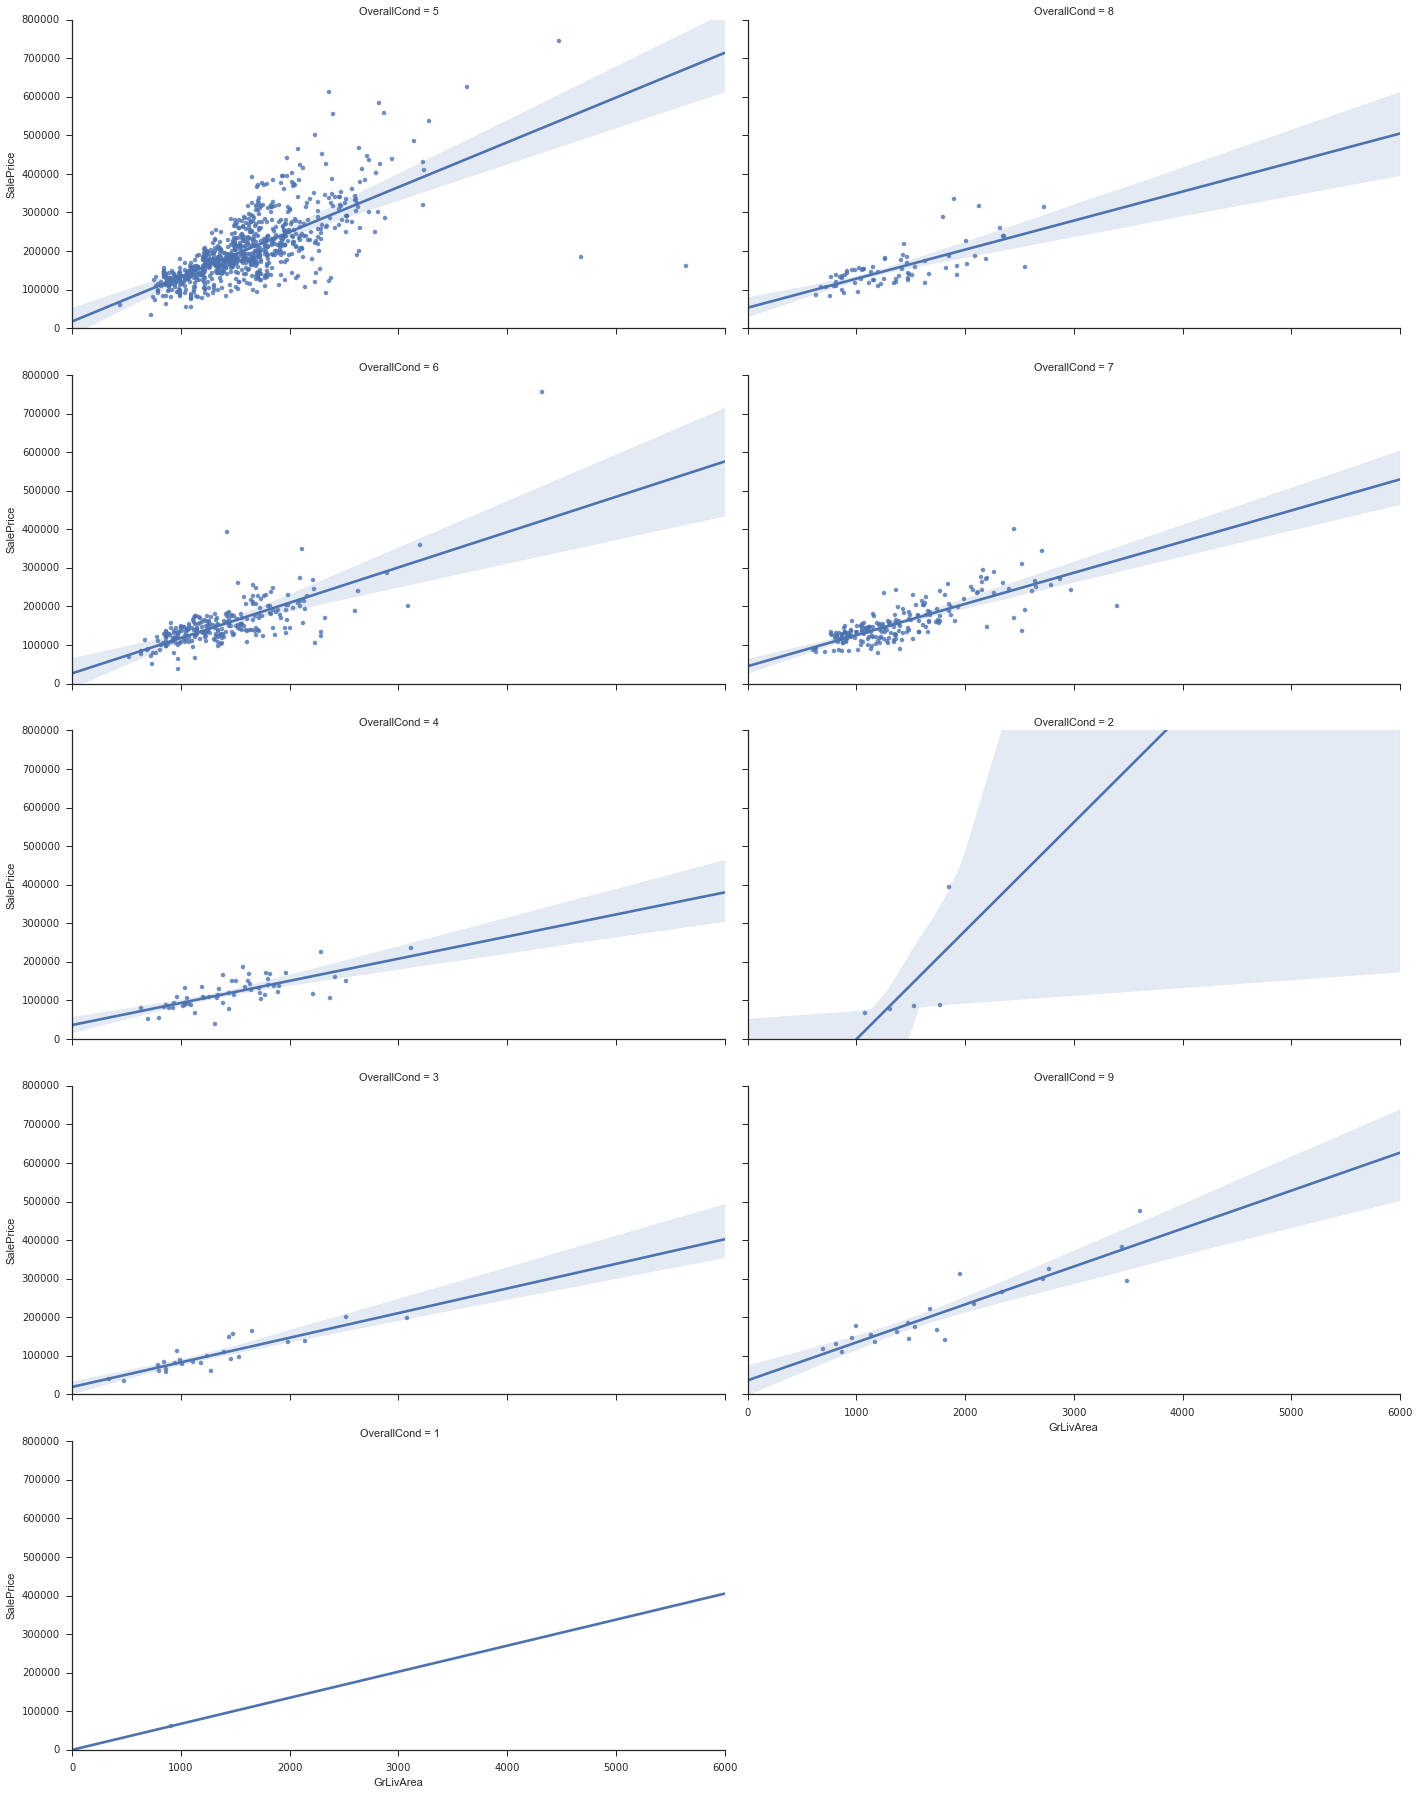

In [409]:
import seaborn as sns
from  matplotlib import pyplot

data = train[['GrLivArea','SalePrice','OverallCond']]
ax = sns.lmplot(data = data, x = 'GrLivArea', 
                y = 'SalePrice', col = 'OverallCond', 
                fit_reg = True, aspect = 2,
                col_wrap = 2)
ax.set(ylim=(0, 800000))
ax.set(xlim=(0, 6000))

sns.plt.show()

In [478]:
# correlation plot with all numeric features
numeric_features = train.dtypes[train.dtypes != 'object'].index
pearson = train[numeric_features].corr(method='pearson')
corr_with_target = pearson.ix[-1][1:-1]
corr_with_target = corr_with_target[abs(corr_with_target).argsort()[::-1]]
print corr_with_target

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


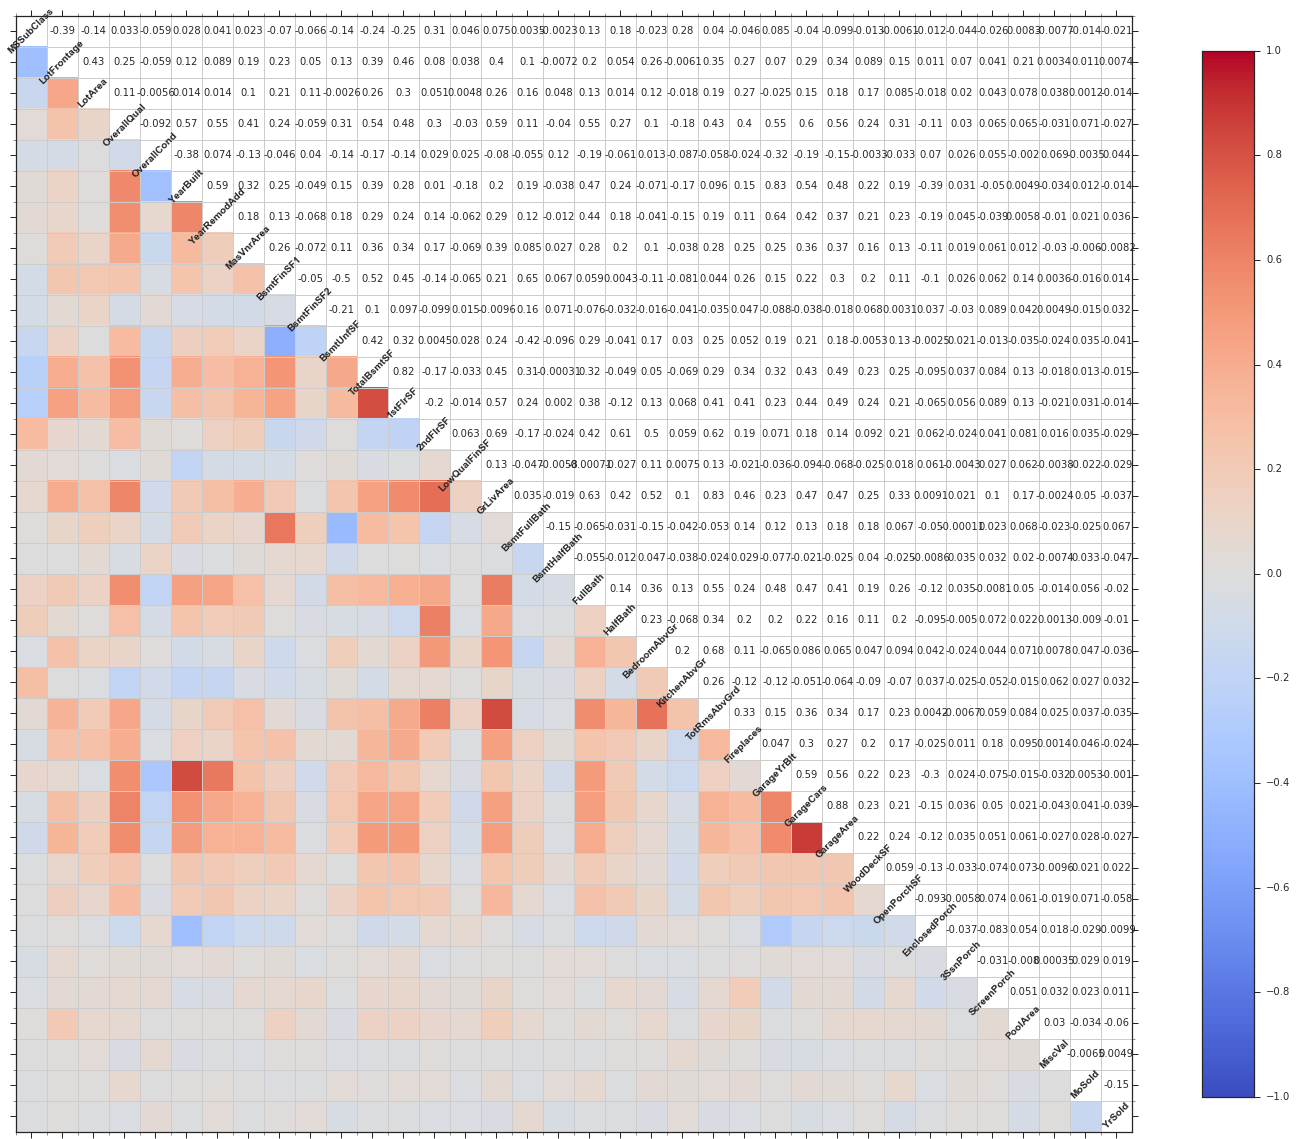

In [506]:
#TotalBsmtSF and 1stFlrSF have .82 correlation
#YearBuilt and GarageYrBuilt have .83 correlation
#GrLivArea and TotRmsAbvGrd have .83 correlation
#GarageCars and GarageArea have .88 correlation
#BsmtFinSF2 and BsmtUntSF have -.5 correlation highest negative
# make a plot of specified dimension (in inches), just a 1x1 subplot
fig, ax = plt.subplots(figsize=(25, 25))
# pass the axis to draw on
sns.corrplot(train[numeric_features[1:-1]], ax=ax)


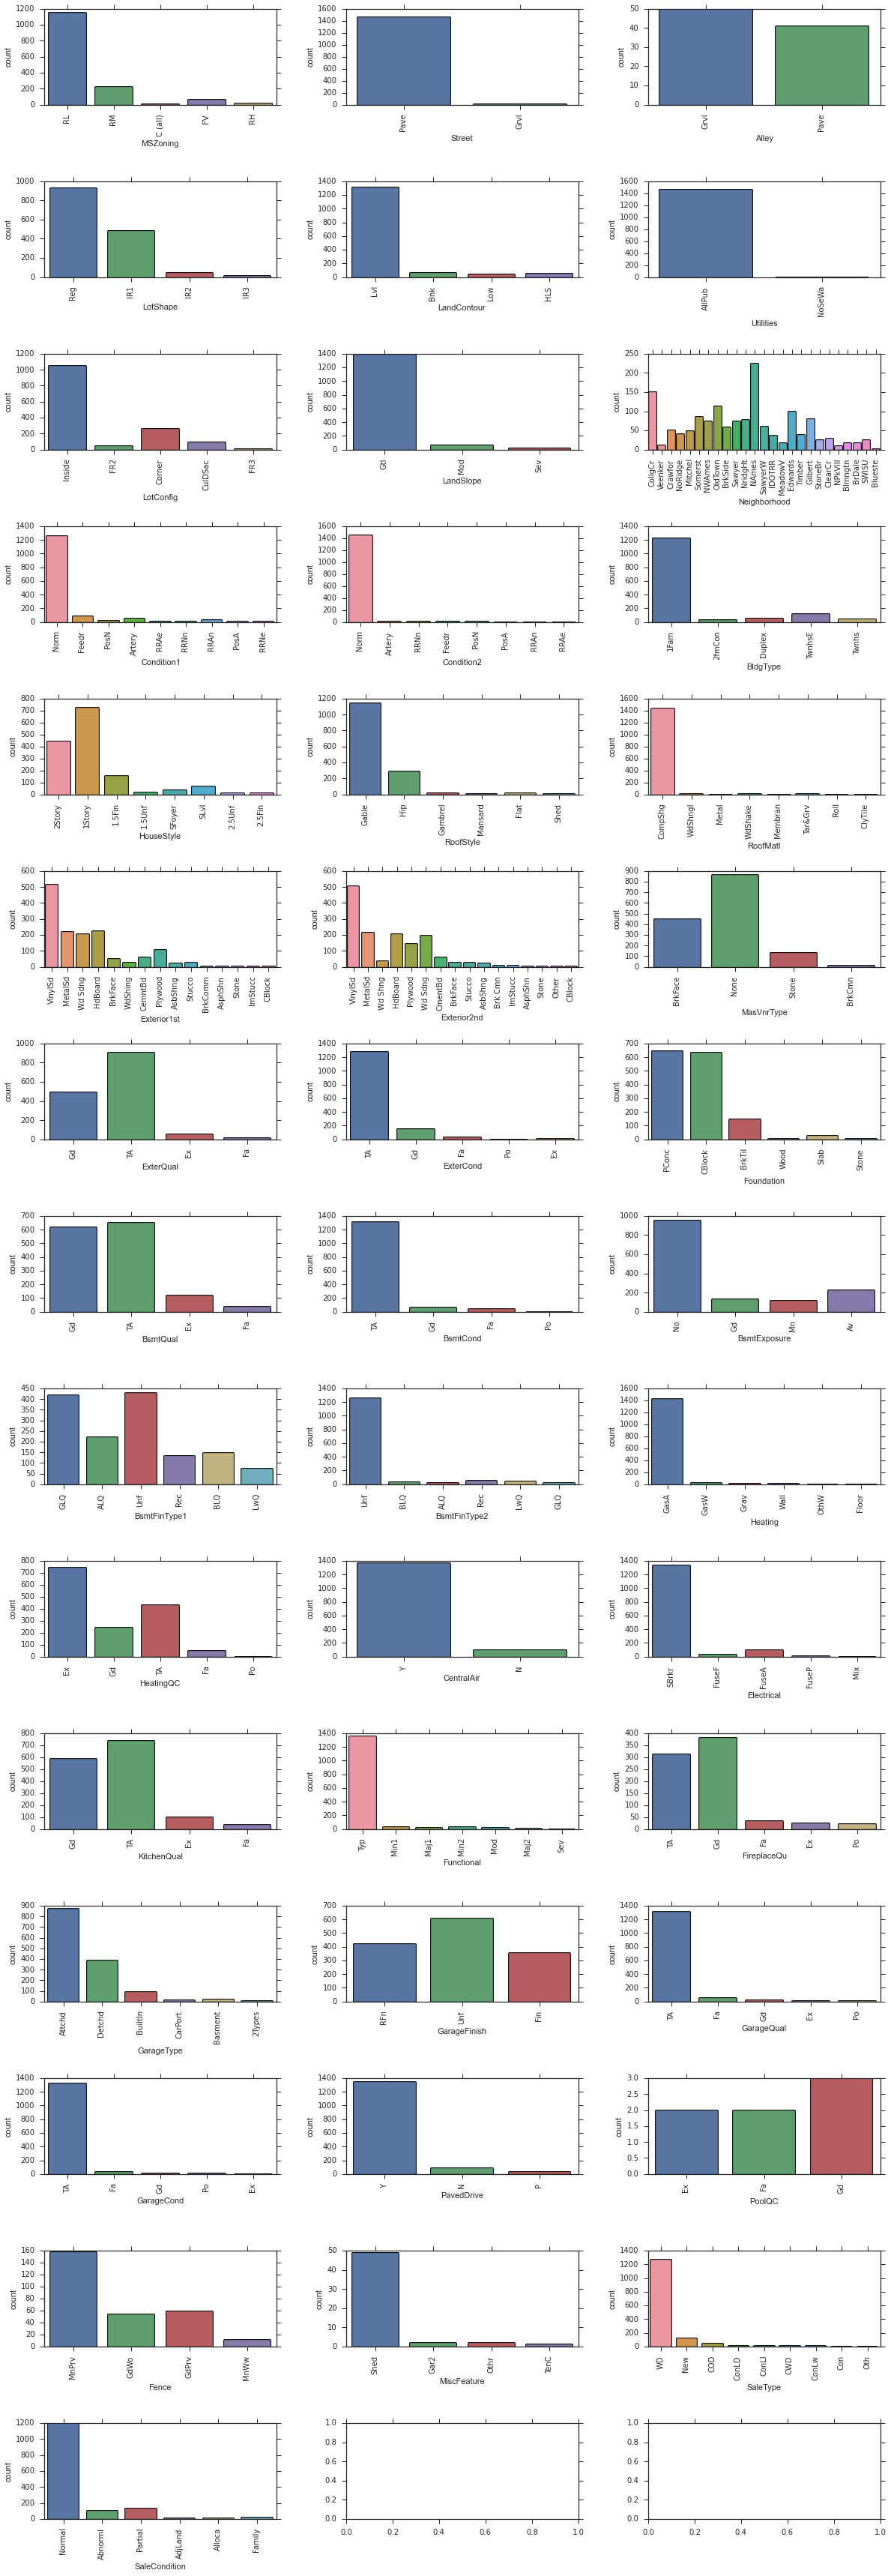

In [568]:
#object features
object_features = train.dtypes[train.dtypes == 'object'].index
n_features1 = 10
n_rows = 15
object_df = train[object_features]

fig, axs = plt.subplots(n_rows,3, figsize = (20,60))

fig.subplots_adjust(hspace=.8, wspace=.3)


for k in axs:
    for i,j in zip(object_features, axs.flat):
        g = sns.countplot(x=i, data=object_df, ax=j)
        plt.setp(j.get_xticklabels(), rotation=90)

In [699]:
# columns with NAs and count
from __future__ import division
print "Train Columns with Nulls \n"
train_nulls = []
for column in train.columns:
    if train[column].isnull().sum() > 0:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, train[column].isnull().sum(), round(train[column].isnull().sum()/len(train),2)*100)
        train_nulls.append(column)
        
#test
test_nulls = []
print "\nTest Columns with Nulls \n"
for column in test.columns:
    if test[column].isnull().sum() > 0:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, test[column].isnull().sum(), round(test[column].isnull().sum()/len(test),2)*100.0)
        test_nulls.append(column)
        


Train Columns with Nulls 

Column: LotFrontage has 259 nulls which is 18.0%
Column: Alley has 1369 nulls which is 94.0%
Column: MasVnrType has 8 nulls which is 1.0%
Column: MasVnrArea has 8 nulls which is 1.0%
Column: BsmtQual has 37 nulls which is 3.0%
Column: BsmtCond has 37 nulls which is 3.0%
Column: BsmtExposure has 38 nulls which is 3.0%
Column: BsmtFinType1 has 37 nulls which is 3.0%
Column: BsmtFinType2 has 38 nulls which is 3.0%
Column: Electrical has 1 nulls which is 0.0%
Column: FireplaceQu has 690 nulls which is 47.0%
Column: GarageType has 81 nulls which is 6.0%
Column: GarageYrBlt has 81 nulls which is 6.0%
Column: GarageFinish has 81 nulls which is 6.0%
Column: GarageQual has 81 nulls which is 6.0%
Column: GarageCond has 81 nulls which is 6.0%
Column: PoolQC has 1453 nulls which is 100.0%
Column: Fence has 1179 nulls which is 81.0%
Column: MiscFeature has 1406 nulls which is 96.0%

Test Columns with Nulls 

Column: MSZoning has 4 nulls which is 0.0%
Column: LotFrontage h

In [708]:
# there seems to be a lot of nulls in a lot of columns, lets put a 10% constraint on it,
# The train columns are equal to test columns. The percentages are about the same. Alley, PoolQC,
# Fence, and MiscFeature have a high percentage of nulls which means there is a lot of missing data.
# it is probably ok to drop these columns.

limit = .70
#train
train_nulls_less_70 = []
train_remove = []
print "Train Columns with Nulls > 70%\n"
for column in train_nulls:
    if float(train[column].isnull().sum()/len(train)) > limit:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, train[column].isnull().sum(), round(train[column].isnull().sum()/len(train),2)*100)
        train_remove.append(column)
    else:
        train_nulls_less_70.append(column)
        
#test
test_nulls_less_70 = []
test_remove = []
print "\nTest Columns with Nulls > 70%\n"
for column in test_nulls:
    if float(test[column].isnull().sum()/len(test)) > limit:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, test[column].isnull().sum(), round(test[column].isnull().sum()/len(test),2)*100.0)
        test_remove.append(column)
    else:
        test_nulls_less_70.append(column)
        


Train Columns with Nulls > 70%

Column: Alley has 1369 nulls which is 94.0%
Column: PoolQC has 1453 nulls which is 100.0%
Column: Fence has 1179 nulls which is 81.0%
Column: MiscFeature has 1406 nulls which is 96.0%

Test Columns with Nulls > 70%

Column: Alley has 1352 nulls which is 93.0%
Column: PoolQC has 1456 nulls which is 100.0%
Column: Fence has 1169 nulls which is 80.0%
Column: MiscFeature has 1408 nulls which is 97.0%


In [783]:
# remove the columns from train and test
train.drop(train_remove, axis = 1, inplace = True)
test.drop(test_remove, axis = 1, inplace = True)

In [714]:
print train_nulls_less_70
#Electrical null is not part of factors

['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']


In [765]:
#try to find similar obsverations like null electrical
electrical_null_values = train[train['Electrical'].isnull()]\
[['Utilities','YearBuilt','Heating','HeatingQC','CentralAir']].values

electrical_no_null_values = train[train['Electrical'].notnull()]\
[['Utilities','YearBuilt','Heating','HeatingQC','CentralAir']]

electrical_similar_index = [] #index of similar no null values to null values
for index, row in electrical_no_null_values.iterrows(): #iterate over all rows
    if (row.values == electrical_null_values).sum() == 5: #if same values
        electrical_similar_index.append(index) #append to list

In [778]:
#take a look at what it is
electrical_similar_values = train.ix[electrical_similar_index,:]['Electrical']
print electrical_similar_values.unique()

['SBrkr']


In [779]:
#change the null to SBrkr
train.ix[train['Electrical'].isnull(), 'Electrical'] = electrical_similar_values.unique()

In [718]:
print test_nulls_less_70
#null not part of factors
['MSZoning', 'Utilities', 'Exterior1st','Exterior2nd','KitchenQual','Functional']
#SaleType (change to Other)

['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'SaleType']


In [813]:
#try to find similar obsverations like null MSZoning
MSZoning_null_values = test[test['MSZoning'].isnull()]\
[['LotShape','LandContour','LandSlope','Neighborhood']].values

MSZoning_num_nulls = len(MSZoning_null_values) #number of nulls

MSZoning_no_null_values = train[train['MSZoning'].notnull()]\
[['LotShape','LandContour','LandSlope','Neighborhood']]

MSZoning_similar_index = {sec : [] for sec in range(0,MSZoning_num_nulls)}#index of similar no null values to null values

for key, values in enumerate(MSZoning_null_values):
    for index, row in MSZoning_no_null_values.iterrows(): #iterate over all rows
        if (row.values == values).sum() == 4: #if same values
            MSZoning_similar_index[key].append(index) #append to list

In [791]:
#take a look at what it is
MSZoning_similar_values = test.ix[MSZoning_similar_index,:]['MSZoning']
print MSZoning_similar_values.unique()

['RL' 'RM']


In [814]:
MSZoning_similar_index

{0: [30,
  61,
  104,
  108,
  121,
  125,
  268,
  296,
  325,
  329,
  365,
  398,
  495,
  653,
  705,
  729,
  801,
  896,
  916,
  998,
  1096,
  1153,
  1279,
  1325,
  1333,
  1385],
 1: [557],
 2: [],
 3: [71,
  81,
  137,
  201,
  274,
  420,
  454,
  483,
  547,
  592,
  613,
  775,
  779,
  984,
  1048,
  1131,
  1170,
  1193,
  1252,
  1327,
  1453]}

In [810]:
{sec : [] for sec in range(1,MSZoning_num_nulls)}

{1: [], 2: [], 3: []}

In [693]:
#match categorical values with test data set
for column in object_features:
    a = train[column].unique()
    b = test[column].unique()
    print "train: %s, test: %s" %(a, b)



train: ['RL' 'RM' 'C (all)' 'FV' 'RH'], test: ['RH' 'RL' 'RM' 'FV' 'C (all)' nan]
train: ['Pave' 'Grvl'], test: ['Pave' 'Grvl']
train: [nan 'Grvl' 'Pave'], test: [nan 'Pave' 'Grvl']
train: ['Reg' 'IR1' 'IR2' 'IR3'], test: ['Reg' 'IR1' 'IR2' 'IR3']
train: ['Lvl' 'Bnk' 'Low' 'HLS'], test: ['Lvl' 'HLS' 'Bnk' 'Low']
train: ['AllPub' 'NoSeWa'], test: ['AllPub' nan]
train: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3'], test: ['Inside' 'Corner' 'FR2' 'CulDSac' 'FR3']
train: ['Gtl' 'Mod' 'Sev'], test: ['Gtl' 'Mod' 'Sev']
train: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste'], test: ['NAmes' 'Gilbert' 'StoneBr' 'BrDale' 'NPkVill' 'NridgHt' 'Blmngtn'
 'NoRidge' 'Somerst' 'SawyerW' 'Sawyer' 'NWAmes' 'OldTown' 'BrkSide'
 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor' 'Blueste' 'IDOTRR'
 'Mitchel' 'Timber' 